In [338]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

In [340]:
#From
#https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey
sdss=pd.read_csv('/Users/sdodelso/AI_Institute/Course/Skyserver_SQL2_27_2018 6_51_39 PM.csv')

In [343]:
## Convert class column to integer
sdss["class"]=np.where(sdss["class"]=='QSO','2',sdss["class"])#.astype(int)
sdss["class"]=np.where(sdss["class"]=='STAR','0',sdss["class"])#.astype(int)
sdss["class"]=np.where(sdss["class"]=='GALAXY','1',sdss["class"])#.astype(int)
sdssc=sdss.astype({'class':int})
#sdssc.info()

We want to see if we can distinguish between QSOs and stars. Galaxies can be more easily distinguished typically because they
are bigger, although that begins to fail for faint galaxies

In [353]:
## First simply remove the galaxies
point_sources = sdssc[sdssc["class"]!=1]
print(np.shape(point_sources))
## Now create the labels (or targets) and remove those from the frame
y = point_sources["class"]
X=point_sources.drop(columns="class",axis=1)
print(np.shape(y),np.shape(X))
### Now create a training set and a test set
ntrain=int(.8*np.shape(X)[0])
Xtrain,Xtest,ytrain,ytest=X[:ntrain],X[ntrain:],y[:ntrain],y[ntrain:]
print(np.shape(ytrain),np.shape(Xtrain))


(5002, 18)
(5002,) (5002, 17)
(4001,) (4001, 17)


In [381]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler #scale the data
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(Xtrain,ytrain)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [392]:
st_predict=clf.predict(Xtrain)
print(st_predict[2],st_predict.shape)
confusion_matrix(ytrain,st_predict)

0 (4001,)


array([[3326,    2],
       [   9,  664]])

In [400]:
#So there are 3326 stars correctly identified and 664 qso correctly identified.
#Check this:
star_matches=0
print(np.size(np.where(st_predict==0)))
for i in range(ntrain):
    if (ytrain.iloc[i]==2):
        if (st_predict[i])==2:
            star_matches+=1
print(star_matches)

3335
664


So, this simple classifier does pretty well, correctly separating QSOs from stars. Let's try it on the test set

In [401]:
st_predict_test=clf.predict(Xtest)
confusion_matrix(ytest,st_predict_test)

array([[824,   0],
       [  2, 175]])

nice!

In [416]:
# Can we try to find the coefficients:
n=np.shape(Xtrain)[1]
print(Xtrain.columns)
print(clf.named_steps['sgdclassifier'].coef_)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')
[[-3.17572336 -0.24951561  0.37939897 -0.91710154  3.17124486 -0.14032076
  -1.60904882 -0.76365171 -0.15408977  0.          0.39220797 -0.225937
  -0.01277408 12.34478405 -0.01276902 -0.28985543  0.06794617]]


not really fair because the redshift is given, so remove the redshift column, and just to make sure remove the plate column as well.

In [418]:
X=point_sources.drop(columns=["class","redshift","plate"],axis=1)
print(np.shape(y),np.shape(X))
### Now create a training set and a test set
ntrain=int(.8*np.shape(X)[0])
Xtrain,Xtest,ytrain,ytest=X[:ntrain],X[ntrain:],y[:ntrain],y[ntrain:]
print(np.shape(ytrain),np.shape(Xtrain))


(5002,) (5002, 15)
(4001,) (4001, 15)


In [429]:
clf.fit(Xtrain,ytrain)
st_predict=clf.predict(Xtrain)
print(st_predict[2],st_predict.shape)
confusion_matrix(ytrain,st_predict)

0 (4001,)


array([[3279,   49],
       [  88,  585]])

In [430]:
#more reasonable i guess with 67 of the stars mis-classified as QSOs and 87 of the QSO's 
#mis-classified as stars. Check this:
star_misses=0
for i in range(ntrain):
    if (ytrain.iloc[i]==0):
        if (st_predict[i])==2:
            star_misses+=1
print(star_misses)

49


In [431]:
#Quantitatively, 
cm=confusion_matrix(ytrain,st_predict)
precision = cm[0,0]/(cm[0,0]+cm[0,1])
recall = cm[0,0]/(cm[0,0]+cm[1,0])
print(precision,recall)
#on QSOs
precision = cm[1,1]/(cm[1,1]+cm[1,0])
recall = cm[1,1]/(cm[1,1]+cm[0,1])
print(precision,recall)

0.9852764423076923 0.9738639738639738
0.8692421991084696 0.9227129337539433


In [432]:
#Now try on test set
st_predict=clf.predict(Xtest)
confusion_matrix(ytest,st_predict)


array([[813,  11],
       [ 27, 150]])

In [433]:
#Quantitatively, 
cm=confusion_matrix(ytest,st_predict)
precision = cm[0,0]/(cm[0,0]+cm[0,1])
recall = cm[0,0]/(cm[0,0]+cm[1,0])
print(precision,recall)
#on QSOs
precision = cm[1,1]/(cm[1,1]+cm[1,0])
recall = cm[1,1]/(cm[1,1]+cm[0,1])
print(precision,recall)

0.9866504854368932 0.9678571428571429
0.847457627118644 0.9316770186335404


In [434]:
#look at the coefficients
print(Xtrain.columns)
print(clf.named_steps['sgdclassifier'].coef_)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'mjd', 'fiberid'],
      dtype='object')
[[-4.14533041e+00  3.27635164e-01  2.22357538e-03 -5.15812352e+00
   1.05092705e+01  4.26776872e-01 -1.71346735e+00 -3.72953470e+00
  -2.12812216e-01  0.00000000e+00  1.14576562e-01 -7.96585274e-02
   2.26458194e-01 -5.62589801e-01  1.68619150e-01]]


Text(0.5, 1.0, 'QSO: yellow; Stars: blue')

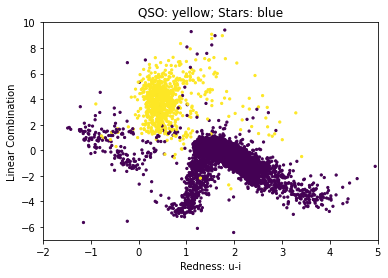

In [474]:
#looks like u,g,i,z are most important. look at colors: 
# bluest things have large values of i-u. brightest things have smallest g:
u=point_sources["u"]
u=(u-np.mean(u))/np.std(u)
g=point_sources["g"]
g=(g-np.mean(g))/np.std(g)
i=point_sources["i"]
i=(i-np.mean(i))/np.std(i)
r=point_sources["r"]
r=(r-np.mean(r))/np.std(r)
z=point_sources["z"]
z=(z-np.mean(z))/np.std(z)
o=point_sources["objid"]
o=(o-np.mean(o))/np.std(o)

plt.scatter(point_sources["u"]-point_sources["i"],-5.16*u+10.5*g+.427*r-1.71*i-3.73*z,s=5,alpha=1,c=point_sources["class"])
plt.axis([-2,5,-7,10])
plt.xlabel('Redness: u-i')
plt.ylabel("Linear Combination")
plt.title('QSO: yellow; Stars: blue')

So, stars are redder, but just cutting on redness (collapsing the y-axis) doesn't do as good a job as collapsing the x-axis